# Lab 2 - Cross-Validation
In this lab we implement and study different cross-validation algorithms for the tuning of k-NN hyperparameters (in particular the number of nearest neighbors k).

In [1]:
# Packages used
# Andres        Coronado    2761046
# Garbarino     Giacomo     4545532
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import griddata
from matplotlib.ticker import MaxNLocator
np.random.seed(100)

## k-NN Classification
The functions used in the previous labs for k-NN are reported here.

In [2]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D

def fast_allDistances(X1, X2):
    

# size of matrixes
    M = X1.shape[0]
    N = X2.shape[0]

# check
    assert X1.shape[1] == X2.shape[1], f"The number of components for vectors in X1 \
        { X1.shape[1]} does not match that of B {X2.shape[1]}!"

    A_dots = (X1*X1).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (X2*X2).sum(axis=1)*np.ones(shape=(M,1))
    D_squared =  A_dots + B_dots -2*X1.dot(X2.T)
    zero_mask = np.less(D_squared, 0.0)
    D_squared[zero_mask] = 0.0
    return np.sqrt(D_squared)

In [3]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0]
    n_test = Xte.shape[0]

    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    dist = fast_allDistances(Xte, Xtr)

    for idx in range(n_test):
        neigh_indexes = np.argsort(dist[idx, :])[:k]
        avg_neigh = np.mean(Ytr[neigh_indexes])
        Ypred[idx] = np.sign(avg_neigh)

    return Ypred

In [4]:
def separatingFkNN(Xtr, Ytr, k):
    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xtr)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 200)
    yi = np.linspace(y.min(), y.max(), 200)
    zi = griddata((x, y), Ypred, (xi[None, :], yi[:, None]), method='linear')

    fig, ax = plt.subplots()
    CS = ax.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    ax.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(x.min(), x.max())
    msg = f"Separating function, k={k}"
    ax.set_title(msg)
    return fig, ax

In [5]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

## Preliminaries: Data-loading

There are 4 datasets included with this lab, with the following properties:

  - (Training1, Test1): n=70, no noise, suggested K values are in the range 1 ... 13
  - (Training2, Test2): n=40, no noise, suggested K values are in the range 1 ... 23
  - (Training3, Test3): n=200, 20% flipped labels, suggested K values are in the range 1 ... 31
  - (Training4, Test4): n=200, 5% flipped labels, suggested K values are in the range 1 ... 19

Note that each dataset includes both a training and a test set. You **cannot use the test set to choose k**: you should assume you don't have access to the test set when doing model selection!

To load a dataset use function
`Xtr, Ytr, Xte, Yte = load_dataset(path_tr, path_te)`

Where:
- **_path\_tr_**: is the path to the file which contains the training set
- **_path\_te_**: is the path to the file which contains the test set

and it returns:
- **_Xtr_**: Inputs of training set
- **_Ytr_**: Outputs of training set
- **_Xte_**: Inputs of test set
- **_Yte_**: Outputs of test set

In [6]:
def load_dataset(path_tr, path_te):
    with open(path_tr,"rb") as f:
        [Xtr, Ytr] = pickle.load(f)
    with open(path_te,"rb") as f:
        [Xte, Yte] = pickle.load(f)
    return Xtr, Ytr, Xte, Yte

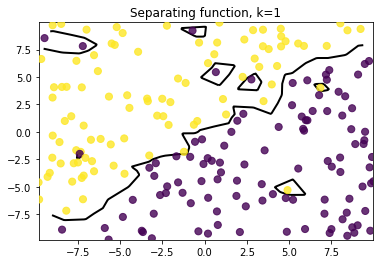

In [7]:
training_set_path = "./Material/Classification/Training4.dat"
test_set_path = "./Material/Classification/Test4.dat"
Xtr, Ytr, Xte, Yte = load_dataset(training_set_path, test_set_path)
separatingFkNN(Xtr, Ytr, 1);

## Using the training set to choose k

Having noted that we cannot directly use the test set to find the best k, we can try to select it with the training set. 
Follow these steps, and fill in the blanks in the following cells. **Comment on your findings in the notebook**.

 1. Choose a list of values for k you want to try. Check the list of suggested values for any given dataset.
 2. For each value of k do:
     1. Train a k-NN classifier with the current value of k
     2. Evaluate the error of the trained model, **on the training set**
 3. The _best_ k is the one with the lowest training error!
 4. Train a k-NN model with the chosen k, and evaluate the error **on the test set**. Is the test error similar to the training error? Does the chosen k seem like a good one?

In [8]:
# Use dataset 4 for this task.
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training4.dat", "./Material/Classification/Test4.dat")
k_list = np.array(range(1,20))
k_tr_errors = []


for current_k in k_list:
    Ypredtr = kNNClassify(Xtr, Ytr, current_k, Xtr)
    current_tr_err = calcError(Ypredtr, Ytr) # TODO: train a k-NN model, calculate the error on the training set.
    k_tr_errors.append(current_tr_err)
    
    
best_k = k_list[np.argmin(k_tr_errors)] # TODO: pick the best value of k using k_list and k_tr_errors.
print(f"The best k chosen with the training-set is: {best_k} "
      f"with training error: {np.min(k_tr_errors)*100:.2f}")

The best k chosen with the training-set is: 1 with training error: 0.00


In [9]:
# Evaluate the model with the best k on the test set now
Ypred = kNNClassify(Xtr, Ytr, current_k, Xte)
ts_err = calcError(Ypred, Yte)
print(f"The test error with the best k ({best_k}) is: {ts_err*100:.2f}%")

The test error with the best k (1) is: 7.00%


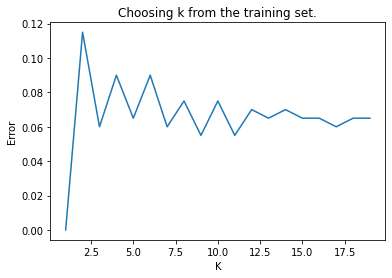

In [10]:
# Plot how the training error changes with k
fig, ax = plt.subplots()
ax.plot(k_list, k_tr_errors)
ax.set_xlabel("K")
ax.set_ylabel("Error")
ax.set_title("Choosing k from the training set.");

## The hold-out estimator

The training error does not provide good estimates of the test error. So using the training error for model selection means you will select a k which is not good for the test set.

A simple way, which is much better than the training error, to estimate the test error is to use a **hold-out set**: a small part of the training set which is held-out from training.

Follow the steps below and fill in the blanks in the following cells. **Comment on your findings in the notebook.**

  1. Split the training set into two parts: a training, and a validation part. For example use 70% of the data for training and 30% for validation. It is important to use random sampling to choose the training/validation splits!
  2. Choose a list of values for k that you want to try.
  3. For each value of k do:
      1. Train a k-NN classifier with the current value of k, using the **training part** of the train/validation split.
      2. Evaluate the classifier's error on the **validation set**.
  4. The _best_ k now is the one with the lowest validation error!
  5. Check whether the hold-out estimate of the test-error is good by (for every k) training a model with the full training set, and testing it on the actual test-set.  
      Ideally this should be true, but the **variance** of the hold-out error may lead to choosing the wrong k.

In [11]:
def train_val_split(x, y, train_fraction):
    """Split a dataset, given by data `x` and labels `y` into a training and a validation set.
    
    Parameters:
    -----------
    x : np.array
        The data matrix
    y : np.array
        The array of labels
    train_fraction : float
        Fraction of the dataset to use for the training set. Consequently the fraction of points used
        for the validation set will be `1 - train_fraction`.
    
    Returns:
    --------
    x_train : np.array
        The training data matrix
    y_train : np.array
        The training labels
    x_val : np.array
        The validation data matrix
    y_val : np.array
        The validation labels
    """
    num_data = x.shape[0]
    random_idx = np.random.permutation(num_data)
    num_train = int(train_fraction * num_data)

    train_idx = random_idx[:num_train]
    val_idx = random_idx[num_train:]
    
    x_train = x[train_idx]
    y_train = y[train_idx]
    x_val = x[val_idx]
    y_val = y[val_idx]
    return x_train, y_train, x_val, y_val

In [12]:
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training4.dat", "./Material/Classification/Test4.dat")

k_list = np.array(range(1,20))

x_train, y_train, x_val, y_val = train_val_split(Xtr, Ytr, 0.70)

k_val_errors = []

for current_k in k_list:
    Ypredtr = kNNClassify(x_train, y_train, current_k, x_val)
    current_val_err = calcError(Ypredtr, y_val)
    k_val_errors.append(current_val_err)

best_k = k_list[np.argmin(k_val_errors)]
print(f"The best k chosen with the validation set is: {best_k} "
      f"with validation error {np.min(k_val_errors)*100}%")

The best k chosen with the validation set is: 1 with validation error 8.333333333333332%


In [13]:
# Check whether the test-error agrees with the hold-out error
k_test_errors = []
for current_k in k_list:
    test_preds = kNNClassify(Xtr, Ytr, current_k, Xte)  # Here we retrain on the full training set.
    current_test_err = calcError(test_preds, Yte)
    k_test_errors.append(current_test_err)
best_test_k = k_list[np.argmin(k_test_errors)]
print(f"The best k for the actual test set is: {best_test_k}, "
      f"with test error {np.min(k_test_errors)*100:.2f}%")

The best k for the actual test set is: 5, with test error 6.50%


Now plot the validation and test errors as a function of k.  
**Bonus question:** can you modify the code to calculate and plot the training error? 

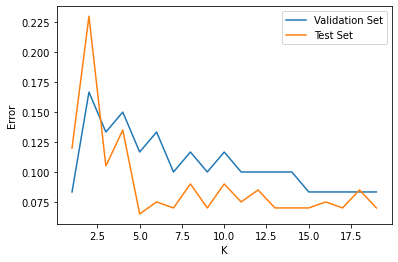

In [14]:
# Plot the validation and test errors
fig, ax = plt.subplots()
ax.plot(k_list, k_val_errors, label="Validation Set")
ax.plot(k_list, k_test_errors, label="Test Set")
ax.set_xlabel("K")
ax.set_ylabel("Error")
ax.legend();

## Variance of the hold-out

If you run the previous task a few times, each time with a different data-split, you will notice that sometimes the best k chosen with the hold-out method coincides with the best k on the test set.
Sometimes however the choice done with the hold-out does not match the best k!

The reason for this discrepancy lies in the **variance** of the hold-out estimator: whether or not it matches the test set depends on which data-split was taken.
To mitigate the effect of a high variance, a common thing to do is to take the **average of many random splits**.

In this task we will take multiple hold-out estimates of the error, and use their mean to find the best k. We will also plot the standard deviation to get an idea of how the variance might influence results.

The task is very similar to the previous one, but you should repeat steps 1, 2, 3 for the number of times you want to split the dataset (e.g. 10), each time using a different train/validation split.

Store the error for each split, and for each value of k in a 2D array, so that at the end it will be easy to find the mean and standard deviation of the errors.

**Question:** Does the value of the best k chosen using multiple hold-out sets, match the best k on the test set (from the previous task)? Why/Why not?

In [15]:
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training4.dat", "./Material/Classification/Test4.dat")

num_splits = 10 #decided by us
k_list = np.array(range(1,20))
# tr_errors, val_errors are 2D arrays which hold all the error estimates (for each k and for each split)
tr_errors = np.zeros((len(k_list), num_splits))
val_errors = np.zeros((len(k_list), num_splits))

for split_idx in range(num_splits):
    # Generate a random data-split (we have a function for that!)
    x_train, y_train, x_val, y_val = train_val_split(Xtr, Ytr, 0.70)
    
    for k_idx, current_k in enumerate(k_list):
        # Compute the training error of the kNN classifier for the given value of k
        tr_errors[k_idx, split_idx] = calcError(kNNClassify(x_train, y_train, current_k, x_train), y_train)
        # Compute the validation error of the kNN classifier for the given value of k
        val_errors[k_idx, split_idx] = calcError(kNNClassify(x_train, y_train, current_k, x_val), y_val)

# Now we can calculate the mean and standard deviation over the data-splits
tr_err_mean = np.mean(tr_errors, axis=1)
tr_err_std = np.std(tr_errors, axis=1)
val_err_mean = np.mean(val_errors, axis=1)
val_err_std = np.std(val_errors, axis=1)

best_k = k_list[np.argmin(val_err_mean)]
print(f"The best k chosen with {num_splits} hold-out splits is {best_k} with error "
      f"{np.min(val_err_mean) * 100:.2f} +- {val_err_std[np.argmin(val_err_mean)] * 100:.2f}%")

The best k chosen with 10 hold-out splits is 9 with error 8.00 +- 2.33%


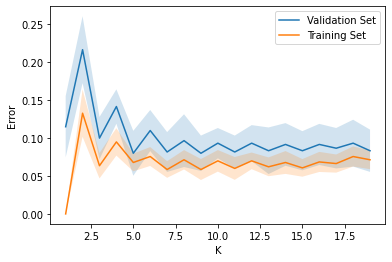

In [16]:
fig, ax = plt.subplots()
ax.plot(k_list, val_err_mean, label="Validation Set")
ax.fill_between(k_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
ax.plot(k_list, tr_err_mean, label="Training Set")
ax.fill_between(k_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)

ax.set_ylabel("Error")
ax.set_xlabel("K")
ax.legend();

## K-Fold cross validation

K-Fold cross validation is a more efficient alternative to taking the mean of several random hold-out sets.

You divide the data into K parts of approximately equal size, and train K different models each time leaving out one of the parts of data. Then the estimate for the test error is the mean of the error of the K different models.

In this task you will implement K-Fold CV, and run the same analysis as in the previous cell.

**Question:** In what way is K-Fold CV different from taking the mean of K hold-out sets?

In [17]:
def KFoldCVkNN(Xtr, Ytr, num_folds, k_list):
    """Run K-Fold CV for the kNN model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - k_list : List[int]
         the values of k (for k-NN) to try.
         
    Returns:
    --------
     - best_k : int
         The value of k (in k_list) which obtains the best average validation error
     - best_k_idx : int
         The index of the best_k element in k_list
     - tr_err_mean : np.array
         A 1D array of the same length as k_list, with the average training error for each tested k.
     - tr_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation 
         of the training error for each tested k.
     - val_err_mean : np.array
         A 1D array of the same length as k_list, with the average validation error for each tested k.
     - val_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation
         of the validation error for each tested k.
    """
    rnd_state = np.random.RandomState()
    # Ensures that k_list is a numpy array
    k_list = np.array(k_list)
    num_k = len(k_list)

    n_tot = Xtr.shape[0]
    n_val = n_tot // num_folds

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_k, num_folds))
    val_errors = np.zeros((num_k, num_folds))

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rnd_state.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        # Split training set in training part and validation part
        # Hint: you can use boolean mask as index vector to split Xtr and Ytr
        x_train = Xtr[~val_mask]
        y_train = Ytr[~val_mask]
        x_val = Xtr[val_mask]
        y_val = Ytr[val_mask]
        
        for k_idx, current_k in enumerate(k_list):
            # Compute the training error of the kNN classifier for the given value of k
            tr_errors[k_idx, fold_idx] = calcError(kNNClassify(x_train, y_train, current_k, x_train), y_train)
            # Compute the validation error of the kNN classifier for the given value of k
            val_errors[k_idx, fold_idx] = calcError(kNNClassify(x_train, y_train, current_k, x_val), y_val)
            
    # Calculate error statistics along the repetitions:
    # 1) mean training error, training error standard deviation
    # 2) mean validation error, validation error standard deviation
    # 3) best k (k which minimize mean validation error) and index of best k in k_list
    
    tr_mean = np.mean(tr_errors, axis=1)
    tr_std = np.std(tr_errors, axis=1)
    val_mean = np.mean(val_errors, axis=1)
    val_std = np.std(val_errors, axis=1)

    best_k_idx = np.argmin(val_mean)
    best_k = k_list[best_k_idx]

    return best_k, best_k_idx, tr_mean, tr_std, val_mean, val_std

In [18]:
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training4.dat", "./Material/Classification/Test4.dat")
num_folds = 5
k_list = range(1, 20)
best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(
    Xtr, Ytr, num_folds, k_list)
print(f"The best k chosen with {num_folds} folds is {best_k} with error "
      f"{np.min(val_err_mean) * 100:.2f} +- {val_err_std[np.argmin(val_err_mean)] * 100:.2f}%")

The best k chosen with 5 folds is 13 with error 6.00 +- 2.55%


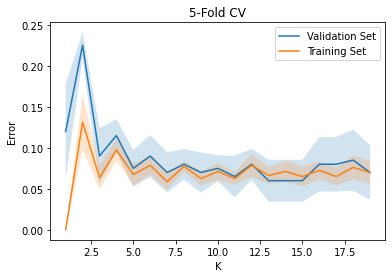

In [19]:
fig, ax = plt.subplots()
ax.plot(k_list, val_err_mean, label="Validation Set")
ax.fill_between(k_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
ax.plot(k_list, tr_err_mean, label="Training Set")
ax.fill_between(k_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)

ax.set_title(f"{num_folds}-Fold CV")
ax.set_ylabel("Error")
ax.set_xlabel("K")
ax.legend();

## Cross validation and Noise in k-NN

In this final task we consider the effect of noise on the best k (chosen with k-fold CV).

We will use dataset 3 which has high noise (20%), and dataset 4 which has low noise (5%).

You will have to do the following:
 1. Use k-fold CV to find the best k for datasets 3 and 4.
 2. Compare the obtained values of k, with the actual best k on the test error of the two datasets. This should be a sanity check: if the errors on k-fold CV and on the test set are very different, something may be wrong with your code.
 3. Comment on how noise affects the best k: does a more noisy dataset need a higher or a lower k, and why? It may be useful to plot the separating function (using the `separatingFkNN` function) of k-NN with the best k for the two datasets.

The best k chosen with 5 folds is 19 with error 22.50 +- 5.48%


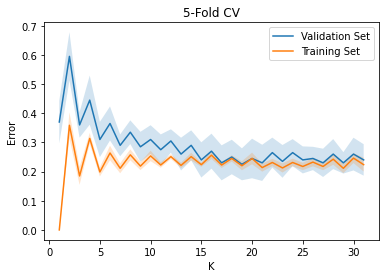

In [20]:
# Use k-fold CV to find best k for dataset 3 (high noise)
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training3.dat", "./Material/Classification/Test3.dat")

num_folds = 5
k_list = range(1, 32)
best_k_ds3, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(
    Xtr, Ytr, num_folds, k_list)
print(f"The best k chosen with {num_folds} folds is {best_k_ds3} with error "
      f"{np.min(val_err_mean) * 100:.2f} +- {val_err_std[np.argmin(val_err_mean)] * 100:.2f}%")

fig, ax = plt.subplots()
ax.plot(k_list, val_err_mean, label="Validation Set")
ax.fill_between(k_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
ax.plot(k_list, tr_err_mean, label="Training Set")
ax.fill_between(k_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)

ax.set_title(f"{num_folds}-Fold CV")
ax.set_ylabel("Error")
ax.set_xlabel("K")
ax.legend();

In [21]:
# Find the best k on the test set of dataset 3
k_test_errors = []
for current_k in k_list:
    test_preds = kNNClassify(Xtr, Ytr, current_k, Xte) 
    current_test_err = calcError(test_preds, Yte)
    k_test_errors.append(current_test_err)
best_test_k_ds3 = k_list[np.argmin(k_test_errors)]
print(f"The best k for the actual test set is: {best_test_k_ds3}, "
      f"with test error {np.min(k_test_errors)*100:.2f}%")

The best k for the actual test set is: 11, with test error 20.00%


The best k chosen with 5 folds is 7 with error 6.50 +- 1.22%


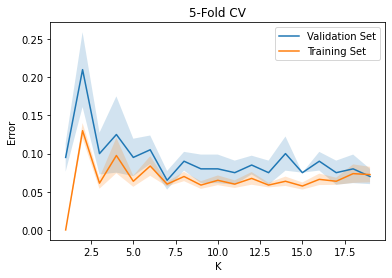

In [22]:
# Use k-fold CV to find best k for dataset 4 (low noise)
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training4.dat", "./Material/Classification/Test4.dat")

num_folds = 5
k_list = range(1, 20)
best_k_ds4, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std = KFoldCVkNN(
    Xtr, Ytr, num_folds, k_list)
print(f"The best k chosen with {num_folds} folds is {best_k_ds4} with error "
      f"{np.min(val_err_mean) * 100:.2f} +- {val_err_std[np.argmin(val_err_mean)] * 100:.2f}%")

fig, ax = plt.subplots()
ax.plot(k_list, val_err_mean, label="Validation Set")
ax.fill_between(k_list, val_err_mean - val_err_std, val_err_mean + val_err_std, alpha=0.2)
ax.plot(k_list, tr_err_mean, label="Training Set")
ax.fill_between(k_list, tr_err_mean - tr_err_std, tr_err_mean + tr_err_std, alpha=0.2)

ax.set_title(f"{num_folds}-Fold CV")
ax.set_ylabel("Error")
ax.set_xlabel("K")
ax.legend();

In [23]:
# Find the best k on the test set of dataset 4
k_test_errors = []
for current_k in k_list:
    test_preds = kNNClassify(Xtr, Ytr, current_k, Xte) 
    current_test_err = calcError(test_preds, Yte)
    k_test_errors.append(current_test_err)
best_test_k_ds4 = k_list[np.argmin(k_test_errors)]
print(f"The best k for the actual test set is: {best_test_k_ds4}, "
      f"with test error {np.min(k_test_errors)*100:.2f}%")

The best k for the actual test set is: 5, with test error 6.50%


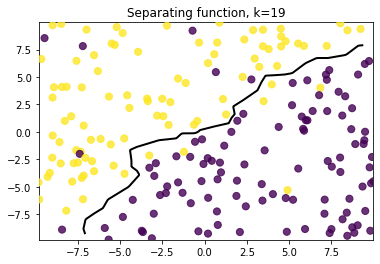

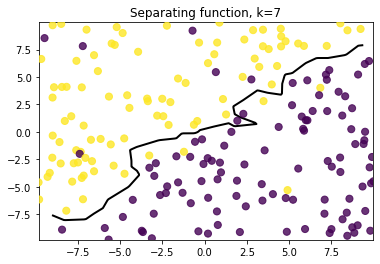

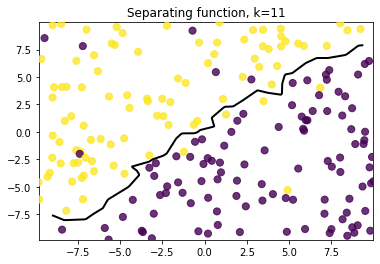

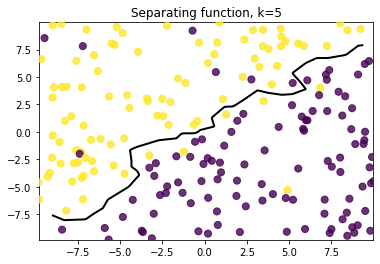

In [24]:
separatingFkNN(Xtr, Ytr, best_k_ds3);
separatingFkNN(Xtr, Ytr, best_k_ds4);
separatingFkNN(Xtr, Ytr, best_test_k_ds3);
separatingFkNN(Xtr, Ytr, best_test_k_ds4);